# MNIST Digit Classification: Capsule Neural Network Implementation

## Project: Digit Detection System  
**Class**: CPT_S 437 Machine Learning  
**Team Members**: Molly Iverson, Caitlin Graves, Chandler Juego  

---

## Summary

### Model Overview
This project implements a Capsule Neural Network (CapsNet) to classify handwritten digits from the MNIST dataset. Unlike traditional neural networks, CapsNets utilize capsules to capture spatial relationships, enhancing the model's ability to understand hierarchical structures in the data. The implementation uses TensorFlow and Keras with custom layers and loss functions.

---

### Dataset

- **Source**: MNIST (Modified National Institute of Standards and Technology) Dataset  
- **Description**: Handwritten digit images  
- **Dimensions**: 28x28 pixel grayscale images  
- **Classes**: 10 digits (0-9)  
- **Training Set Size**: 60,000 images  
- **Test Set Size**: 10,000 images  

---

### Network Architecture

- **Input Layer**: 28x28 grayscale images (reshaped to 28x28x1)  
- **Layer 1: Convolutional Layer**
  - Filters: 256
  - Kernel Size: 9x9
  - Activation: ReLU  
- **Layer 2: Primary Capsule Layer**
  - Convolution: 256 filters, Kernel Size: 9x9, Stride: 2
  - Reshaped to capsules: (-1, 1152, 8)  
  - Activation: Squashing function  
- **Layer 3: Digit Capsule Layer**
  - Capsules: 10
  - Dimensions: 16
  - Routing Iterations: 3  
- **Output Layer**: Capsule length (probability for each class)  

---

### Techniques

#### Preprocessing Data
- **Pixel Normalization**: Scaled pixel values from [0, 255] to [0, 1].  
- **One-Hot Encoding**: Converted integer labels to categorical vectors for multi-class classification.

#### Model Techniques
- **Activation Functions**
  - **Squash Function**: Used in capsule layers to normalize capsule outputs while retaining vector orientation. Ensures outputs are non-linear and bounded.
  - **ReLU Activation**: Applied in initial convolutional layers for computational efficiency and faster convergence.  
- **Routing by Agreement**:
  - Dynamically adjusts capsule connections during training, improving spatial relationship representation.
  - Uses iterative refinement to determine the strength of connections between capsules.  

#### Loss Function
- **Margin Loss**:
  - Encourages correct predictions to have high confidence while penalizing incorrect predictions.
  - Reduces the influence of incorrect predictions without affecting unrelated outputs.

#### Optimization Strategies
- **Adam Optimizer**:
  - Combines adaptive learning rates and momentum for efficient gradient descent.  
- **Mini-Batch Gradient Descent**:
  - Stabilizes training while reducing computation time.  

---

### Results

- **Test Accuracy**: Achieved a classification accuracy of approximately 99% on the MNIST test set after 5 epochs of training.

---

### Advantages of Capsule Neural Networks
1. **Preserves Spatial Relationships**: Capsules retain information about the position and orientation of features, unlike standard dense layers.  
2. **Robust to Affine Transformations**: Better generalizes across variations in input.  
3. **Hierarchical Feature Detection**: Ideal for tasks requiring understanding of spatial hierarchies.  

---

This CapsNet implementation showcases the advanced capabilities of capsule-based architectures for image classification tasks.


In [1]:
# Install necessary libraries
!pip install idx2numpy

import idx2numpy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kagglehub
import pickle
from tensorflow.keras.saving import register_keras_serializable

# Download latest version of dataset
input_path = kagglehub.dataset_download('hojjatk/mnist-dataset')

print('Path to dataset files:', input_path)

training_images_filepath = input_path + '/train-images.idx3-ubyte'
training_labels_filepath = input_path + '/train-labels.idx1-ubyte'
test_images_filepath = input_path + '/t10k-images.idx3-ubyte'
test_labels_filepath = input_path + '/t10k-labels.idx1-ubyte'

# Load the dataset
training_images = idx2numpy.convert_from_file(training_images_filepath)
training_labels = idx2numpy.convert_from_file(training_labels_filepath)
test_images = idx2numpy.convert_from_file(test_images_filepath)
test_labels = idx2numpy.convert_from_file(test_labels_filepath)

# Preprocess the data
X_train = training_images.astype('float32') / 255.0
X_test = test_images.astype('float32') / 255.0

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

Y_train = keras.utils.to_categorical(training_labels, 10)
Y_test = keras.utils.to_categorical(test_labels, 10)

# Define the squash function
@register_keras_serializable()
def squash(vectors, axis=-1):
    """Squashing function."""
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=axis, keepdims=True)
    scale = s_squared_norm / (1.0 + s_squared_norm)
    return scale * vectors / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())

# Corrected CapsuleLayer
@register_keras_serializable()
class CapsuleLayer(layers.Layer):
    """Capsule layer implementation."""
    def __init__(self, num_capsules, dim_capsules, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsules = input_shape[2]
        # Corrected weight matrix dimensions
        self.W = self.add_weight(
            shape=(1, self.input_num_capsules, self.num_capsules, self.input_dim_capsules, self.dim_capsules),
            initializer='glorot_uniform',
            trainable=True,
            name='W'
        )
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs):
        # Expand input dimensions
        inputs_expand = tf.expand_dims(inputs, axis=2)
        inputs_expand = tf.expand_dims(inputs_expand, axis=2)
        # inputs_expand shape: [batch_size, input_num_capsules, 1, 1, input_dim_capsules]

        # Tile inputs and W to match dimensions
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1, 1])
        # inputs_tiled shape: [batch_size, input_num_capsules, num_capsules, 1, input_dim_capsules]

        W_tiled = tf.tile(self.W, [tf.shape(inputs)[0], 1, 1, 1, 1])
        # W_tiled shape: [batch_size, input_num_capsules, num_capsules, input_dim_capsules, dim_capsules]

        # Matrix multiplication
        u_hat = tf.matmul(inputs_tiled, W_tiled)
        # u_hat shape: [batch_size, input_num_capsules, num_capsules, 1, dim_capsules]

        u_hat = tf.squeeze(u_hat, axis=3)
        # u_hat shape: [batch_size, input_num_capsules, num_capsules, dim_capsules]

        # Routing algorithm
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.input_num_capsules, self.num_capsules])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            c = tf.expand_dims(c, -1)
            s = tf.reduce_sum(c * u_hat, axis=1)
            v = squash(s)
            if i < self.routings - 1:
                v_tiled = tf.expand_dims(v, 1)
                b += tf.reduce_sum(u_hat * v_tiled, axis=-1)
        return v

# Build the Capsule Network model
@register_keras_serializable()
def CapsNet(input_shape, n_class, routings):
    inputs = layers.Input(shape=input_shape)

    # Layer 1: Conv2D layer
    conv1 = layers.Conv2D(256, 9, activation='relu')(inputs)

    # Layer 2: Primary Capsule Layer
    primary_caps = layers.Conv2D(256, 9, strides=2, activation='relu')(conv1)
    primary_caps = layers.Reshape((-1, 8))(primary_caps)
    primary_caps = layers.Lambda(squash)(primary_caps)

    # Layer 3: Digit Capsule Layer
    digit_caps = CapsuleLayer(num_capsules=n_class, dim_capsules=16, routings=routings)(primary_caps)

    # Output layer: Length layer to compute the class probabilities
    outputs = layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=-1)))(digit_caps)

    # Define the model
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

# Define the margin loss function
@register_keras_serializable()
def margin_loss(y_true, y_pred):
    """Margin loss for Capsule Network."""
    m_plus = 0.9
    m_minus = 0.1
    lambd = 0.5
    L = y_true * tf.square(tf.maximum(0.0, m_plus - y_pred)) + \
        lambd * (1 - y_true) * tf.square(tf.maximum(0.0, y_pred - m_minus))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

# Instantiate the model
model = CapsNet(input_shape=(28, 28, 1), n_class=10, routings=3)

# Compile the model
model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, batch_size=128, epochs=5, validation_data=(X_test, Y_test))

# Save the model
model.save('capsule_network_model.h5')

# Save the training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)


  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=f47a37968e749d3dc2148e7ade642be8104bb6c9b9e0282c33275dce2ccb02cc
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


100%|██████████| 22.0M/22.0M [00:01<00:00, 15.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3507s 7s/step - accuracy: 0.7044 - loss: 0.2579 - val_accuracy: 0.9843 - val_loss: 0.0188
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3499s 7s/step - accuracy: 0.9881 - loss: 0.0154 - val_accuracy: 0.9921 - val_loss: 0.0105
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3446s 7s/step - accuracy: 0.9929 - loss: 0.0091 - val_accuracy: 0.9926 - val_loss: 0.0089
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3511s 7s/step - accuracy: 0.9959 - loss: 0.0061 - val_accuracy: 0.9928 - val_loss: 0.0085
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3512s 7s/step - accuracy: 0.9972 - loss: 0.0049 - val_accuracy: 0.9936 - val_loss: 0.0078


313/313 ━━━━━━━━━━━━━━━━━━━━ 152s 485ms/step - accuracy: 0.9917 - loss: 0.0096
Test accuracy: 0.9936000108718872


# Evaluate

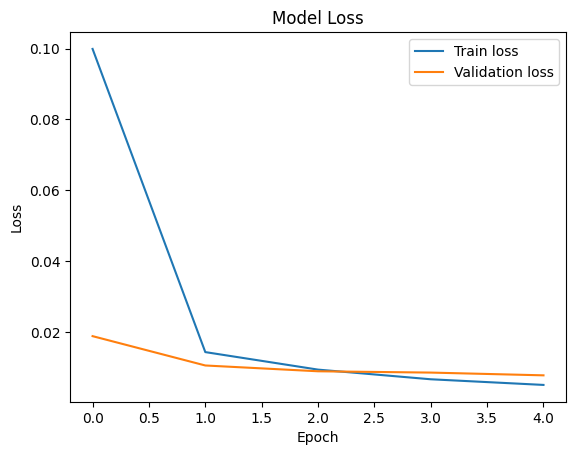

In [3]:
# Plot training & validation loss
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


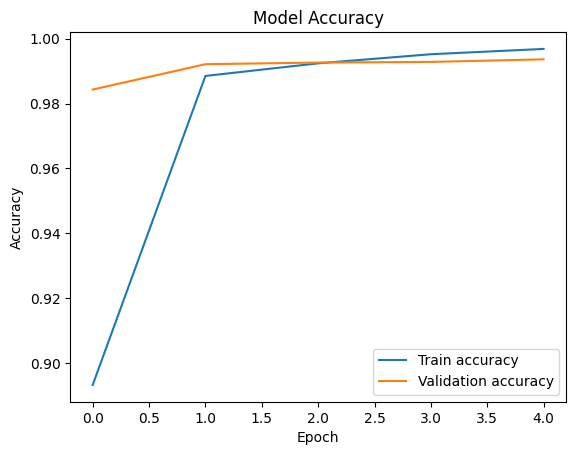

In [4]:
# Plot training & validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [17]:

# Evaluate the loaded model
test_loss_loaded, test_acc_loaded = model.evaluate(X_test, Y_test)
print('Test accuracy of loaded model:', test_acc_loaded)


313/313 ━━━━━━━━━━━━━━━━━━━━ 160s 510ms/step - accuracy: 0.9917 - loss: 0.0096
Test accuracy of loaded model: 0.9936000108718872


In [19]:
from sklearn.metrics import classification_report

# Predict on test data
Y_pred = model.predict(X_test)

# Convert predictions to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(Y_true, Y_pred_classes))


313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 494ms/step
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



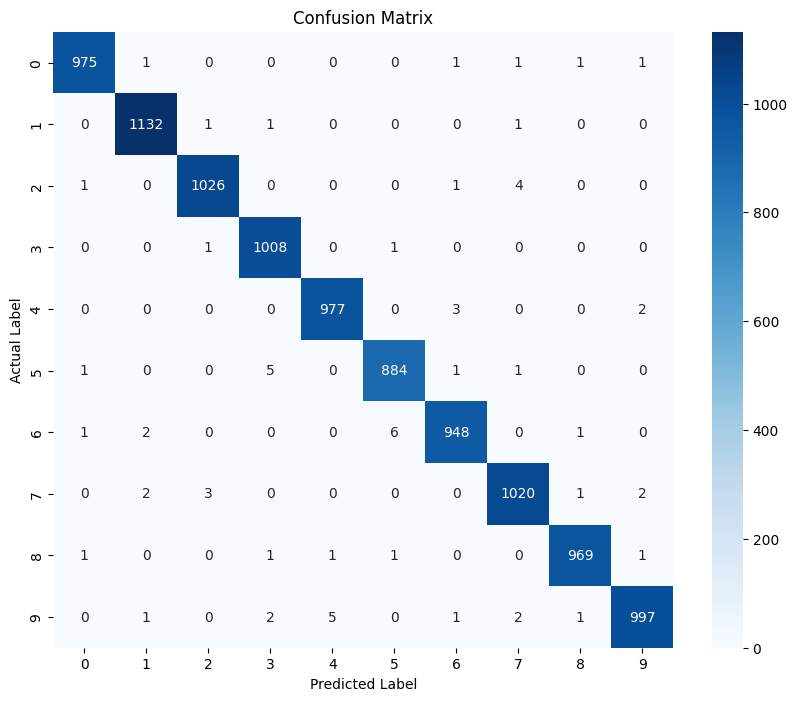

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


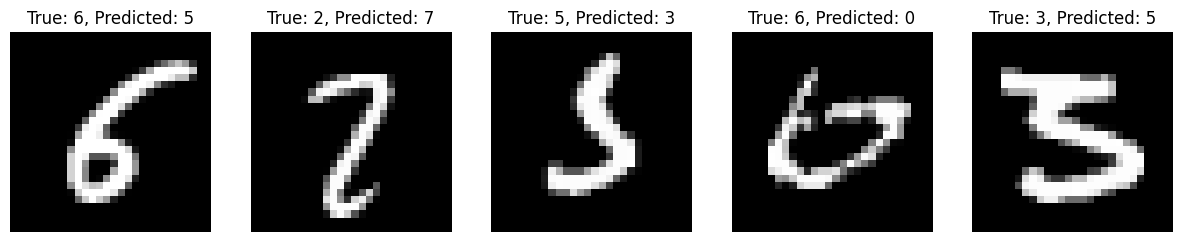

In [21]:
# Find misclassified examples
misclassified_idx = np.where(Y_pred_classes != Y_true)[0]

# Plot some misclassified examples
num_examples = 5
plt.figure(figsize=(15,15))
for i in range(num_examples):
    idx = misclassified_idx[i]
    img = X_test[idx].reshape(28,28)
    plt.subplot(1, num_examples, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {Y_true[idx]}, Predicted: {Y_pred_classes[idx]}")
    plt.axis('off')
plt.show()


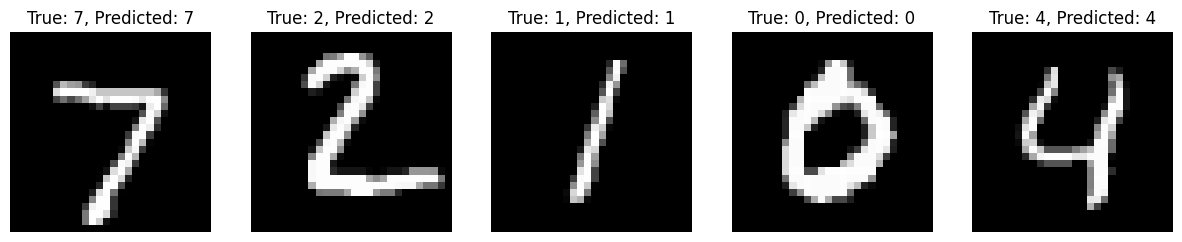

In [22]:
# Find correctly classified examples
correctly_classified_idx = np.where(Y_pred_classes == Y_true)[0]

# Plot some correctly classified examples
num_examples = 5
plt.figure(figsize=(15, 15))
for i in range(num_examples):
    idx = correctly_classified_idx[i]
    img = X_test[idx].reshape(28, 28)
    plt.subplot(1, num_examples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {Y_true[idx]}, Predicted: {Y_pred_classes[idx]}")
    plt.axis('off')
plt.show()
